# Analysis (50 points)

### Overview

All datasets can be obtained by running the code below. The data will be sorted in the `./analysis_data/` folder. The format is the same as that of data you used in the previous part of this assignment, so make sure you change the dataset paths in the *hw2.ipynb* (or *hw2.py*) to the correct data folder, except for the `common_words` stopwords. Also, set the RESET flag to `True`. Finally, make sure you dig around the dataset you are working with, to get familiar with the type of queries and documents, the type of relevance judgements, etc.

### Install

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# !pip install ir_datasets
# !pip install ipywidgets

### Import

In [43]:
import ir_datasets
import csv
import os
from tqdm import tqdm
import random
import json
import numpy as np
from ltr.utils import compare_methods
from ltr.utils import plot_distribution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Function to save data in the .tsv format

In [44]:
def save_tsv(folder_name, dataset_path, concatenate_docs=False, doc_text=None, 
             extract_partial=False, extract=None, provide_n_docs=False, n_docs=None, **kwargs):
    '''
    Saves queries, documents and qrels in asisgnment-specific .tsv format.
    
    Input:
        - dataset_path: dataset to be downloaded using ir_dataset package
        - folder_name: name of the folder within the data_for_analysis folder
    '''
    # Check if the folder exists, and if not, create it
    folder_path = 'analysis_data/'+folder_name
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        dataset = ir_datasets.load(dataset_path)
    
    # Queries
    print(f'Extracting queries of {folder_name} ...')
    query_path = os.path.join(folder_path, 'queries.tsv')
    if not os.path.exists(query_path):
        total_queries = sum(1 for _ in dataset.queries_iter())
        with open(query_path, 'w', newline='', encoding='utf-8') as tsv_file:
            tsv_writer = csv.writer(tsv_file, delimiter='\t')
            for query in tqdm(dataset.queries_iter(), total=total_queries, desc="Saving queries"):
                tsv_writer.writerow([query[0], query[1]])    
        
    # Docs
    print(f'Extracting documents of {folder_name} ...')
    doc_path = os.path.join(folder_path, 'collection.tsv')
    if not os.path.exists(doc_path):
      
        total_docs = n_docs if provide_n_docs else sum(1 for _ in dataset.docs_iter())
        sampled_docs = random.sample(list(dataset.docs_iter()), extract) if extract_partial else dataset.docs_iter()

        with open(doc_path, 'w', newline='', encoding='utf-8') as tsv_file:
            tsv_writer = csv.writer(tsv_file, delimiter='\t')
            for doc in tqdm(dataset.docs_iter(), total=total_docs, desc="Saving docs"):
                if concatenate_docs:
                    tsv_writer.writerow([doc[0], f"{doc[doc_text[0]]} {doc[doc_text[1]]}"])
                else:
                    tsv_writer.writerow([doc[0], doc[1]])
    
    # Qrels
    print(f'Extracting qrels of {folder_name} ...')
    ## Initialize file handles only if they don't exist
    train_file_path = os.path.join(folder_path, 'train_pairs_graded.tsv')
    dev_file_path = os.path.join(folder_path, 'dev_pairs_graded.tsv')
    test_file_path = os.path.join(folder_path, 'test_pairs_graded.tsv')

    if not os.path.exists(train_file_path):
        total_qrels = sum(1 for _ in dataset.qrels_iter())
        
        ## Calculate the indices to split the data
        index_80_percent = int(0.8 * total_qrels)
        index_90_percent = int(0.9 * total_qrels)
        
        with open(os.path.join(folder_path, 'train_pairs_graded.tsv'), 'w', newline='', encoding='utf-8') as train_file, \
                open(os.path.join(folder_path, 'dev_pairs_graded.tsv'), 'w', newline='', encoding='utf-8') as dev_file, \
                open(os.path.join(folder_path, 'test_pairs_graded.tsv'), 'w', newline='', encoding='utf-8') as test_file:

            train_writer = csv.writer(train_file, delimiter='\t')
            dev_writer = csv.writer(dev_file, delimiter='\t')
            test_writer = csv.writer(test_file, delimiter='\t')
            
            for i, qrel in tqdm(enumerate(dataset.qrels_iter()), total=total_qrels, desc="Saving qrels"):
                if i < index_80_percent:
                    train_writer.writerow([qrel[0], qrel[1], qrel[2]])
                elif i < index_90_percent:
                    dev_writer.writerow([qrel[0], qrel[1], qrel[2]])
                else:
                    test_writer.writerow([qrel[0], qrel[1], qrel[2]])

In [45]:
datasets_to_save ={
        'COVID': {
            'dataset_path': 'beir/trec-covid',
            'concatenate_docs': True,
            'doc_text': [2, 1]
        },
        'GENOMICS':  {
            'dataset_path': 'medline/2004/trec-genomics-2005',
            'concatenate_docs': True,
            'doc_text': [1, 2]
        },
        'ARGS': {
            'dataset_path': 'argsme/2020-04-01/touche-2021-task-1',
            'concatenate_docs': True,
            'doc_text': [3, 1]
        },
        'GAMING': {
            'dataset_path': 'beir/cqadupstack/gaming',
            'concatenate_docs': True,
            'doc_text': [2, 1]
        },
        'NUTRITION': {
            'dataset_path': 'nfcorpus/train/nontopic',
            'concatenate_docs': True,
            'doc_text': [2, 3]
        },
        'CLIMATE': {
            'dataset_path': 'beir/climate-fever',
            'concatenate_docs': True,
            'doc_text': [2, 1]
        },
        'BUSINESS': {
            'dataset_path': 'beir/fiqa/train',
        },
    }

### Did you choose your scenario? Let's get the dataset! 
Please use the Dataset name as specified in the markdown cells above.

In [46]:
# scenario = input('What scenario are you interested in? ')
scenario = "NUTRITION"
while scenario not in datasets_to_save.keys():
    print('Please specify a valid scenario.')
    scenario = input('What scenario are you interested in? ')

print(f'Saving {scenario} ...')
save_tsv(scenario, **datasets_to_save[scenario])

Saving NUTRITION ...
Extracting queries of NUTRITION ...
Extracting documents of NUTRITION ...
Extracting qrels of NUTRITION ...


In [47]:
# Additional features:
# - hapax legomena: words that appear only once in the document
# Additional unique features:
# - Jaccard similarity between the query and the document (not sure if this doesn't overlap with query-term coverage)
# - average concreteness of the words in the document


In [48]:
COLLECTION_PATH = f"./analysis_data/{scenario}/collection.tsv"
QUERIES_PATH = f"./analysis_data/{scenario}/queries.tsv"
TRAIN_PATH = f"./analysis_data/{scenario}/train_pairs_graded.tsv"
DEV_PATH = f"./analysis_data/{scenario}/dev_pairs_graded.tsv"
TEST_PATH = f"./analysis_data/{scenario}/test_pairs_graded.tsv"
STOP_WORDS_PATH = "./data/common_words"


from ltr.dataset import Documents, Queries, Preprocess

prp = Preprocess(STOP_WORDS_PATH)

queries = Queries(prp)
queries.preprocess_queries(QUERIES_PATH)

# IMPORTANT: DO NOT CHANGE DOC_JSON PATH
DOC_JSON = f"./analysis_data/{scenario}/doc.pickle"
import os
import pickle

RESET = False

if os.path.exists(DOC_JSON) and not RESET:
    with open(DOC_JSON, "rb") as file:
        documents = pickle.load(file)
else:
    documents = Documents(prp)
    documents.process_documents(COLLECTION_PATH)
    with open(DOC_JSON, "wb") as file:
        pickle.dump(documents, file)

In [49]:
from ltr.dataset import FeatureExtraction, GenerateFeatures

feature_ex = FeatureExtraction({}, documents, queries)

feat_gen = GenerateFeatures(feature_ex)
args = {}
args["k1"] = 1.5
args["b"] = 0.75
args["idf_smoothing"] = 0.5

feat_gen.run(TRAIN_PATH, TRAIN_PATH + "g", **args)
feat_gen.run(DEV_PATH, DEV_PATH + "g", **args)
feat_gen.run(TEST_PATH, TEST_PATH + "g", **args)

2033it [00:00, 3877.34it/s]

29906it [00:06, 4716.86it/s]
3738it [00:00, 5278.12it/s]
3739it [00:00, 5329.06it/s]


In [50]:
from ltr.dataset import DataSet
from ltr.utils import seed, create_results
# from ltr.eval import evaluate_model
from ltr.model import LTRModel
from ltr.train import train_pointwise
# from ltr.train import train_pairwise
from ltr.train import train_pairwise_spedup
from ltr.train import train_listwise
from argparse import Namespace
import torch
seed(42)

N_FEATURES = 15

fold_paths = [f"./analysis_data/{scenario}/"]
num_relevance_labels = 3
num_nonzero_feat = N_FEATURES
num_unique_feat = N_FEATURES
data = DataSet(
    "ir1-2023", fold_paths, num_relevance_labels, num_unique_feat, num_nonzero_feat
)

data = data.get_data_folds()[0]
data.read_data()

In [51]:
metrics={"ndcg", "precision@05", "recall@05"}

In [52]:
params_regr = Namespace(epochs=11, 
                    lr=1e-3,
                    batch_size=1,
                    metrics=metrics)

pointwise_regression_model = LTRModel(data.num_features)
pw_regr = create_results(data, pointwise_regression_model, 
                          train_pointwise, 
                          pointwise_regression_model,
                          "./outputs/pointwise_res.json",
                          params_regr)

torch.save(pointwise_regression_model.state_dict(), "./outputs/analysis_pointwise_model")

Training Model


"metric": "mean" ("standard deviation")
dcg: 28.5150 (14.53520)
dcg@03: 8.3658 (2.65449)
dcg@05: 10.9162 (3.16271)
dcg@10: 15.5123 (4.52256)
dcg@20: 21.0285 (6.87345)
ndcg: 0.9350 (0.06602)
ndcg@03: 0.8070 (0.21758)
ndcg@05: 0.8320 (0.18434)
ndcg@10: 0.8678 (0.14714)
ndcg@20: 0.8992 (0.11457)
precision@01: 0.4565 (0.49811)
precision@03: 0.3043 (0.27650)
precision@05: 0.2391 (0.22504)
precision@10: 0.1761 (0.18319)
precision@20: 0.1174 (0.12947)
recall@01: 0.2852 (0.40851)
recall@03: 0.4937 (0.43494)
recall@05: 0.5713 (0.41339)
recall@10: 0.7157 (0.37392)
recall@100: 1.0000 (0.00000)
recall@20: 0.8656 (0.27075)
relevant rank: 14.6232 (17.70888)
relevant rank per query: 43.8696 (87.10516)


In [53]:

params = Namespace(epochs=10, 
                    lr=1e-3,
                    batch_size=1,
                    metrics=metrics)

sped_up_pairwise_model = LTRModel(data.num_features)

create_results(data, sped_up_pairwise_model, 
               train_pairwise_spedup, 
               sped_up_pairwise_model,
               "./outputs/pairwise_spedup_res.json",
               params)

torch.save(sped_up_pairwise_model.state_dict(), "./outputs/analysis_pairwise_spedup_model")

Training Model


"metric": "mean" ("standard deviation")
dcg: 28.5765 (14.53380)
dcg@03: 8.3846 (2.67070)
dcg@05: 10.9947 (3.29502)
dcg@10: 15.5297 (4.59534)
dcg@20: 21.0551 (6.78114)
ndcg: 0.9380 (0.06177)
ndcg@03: 0.8056 (0.21111)
ndcg@05: 0.8348 (0.18041)
ndcg@10: 0.8681 (0.14509)
ndcg@20: 0.9013 (0.11066)
precision@01: 0.5000 (0.50000)
precision@03: 0.3007 (0.27390)
precision@05: 0.2457 (0.23793)
precision@10: 0.1717 (0.19015)
precision@20: 0.1130 (0.12088)
recall@01: 0.2972 (0.40534)
recall@03: 0.4605 (0.42232)
recall@05: 0.5751 (0.41271)
recall@10: 0.6839 (0.38131)
recall@100: 1.0000 (0.00000)
recall@20: 0.8490 (0.26957)
relevant rank: 15.4384 (19.27245)
relevant rank per query: 46.3152 (93.42178)


In [55]:
params_regr = Namespace(
    epochs=11, lr=1e-4, batch_size=1, metrics=metrics
)

model = LTRModel(data.num_features)

pw_regr = create_results(
    data,
    model,
    train_listwise,
    model,
    "./outputs/analysis_res_15.json",
    params_regr,
)

torch.save(model.state_dict(), "./outputs/analysis_liswise_model")


Training Model


"metric": "mean" ("standard deviation")
dcg: 28.6203 (14.58455)
dcg@03: 8.3729 (2.72633)
dcg@05: 11.0027 (3.31047)
dcg@10: 15.6335 (4.50488)
dcg@20: 21.1949 (6.93359)
ndcg: 0.9400 (0.06475)
ndcg@03: 0.8092 (0.22524)
ndcg@05: 0.8374 (0.18847)
ndcg@10: 0.8742 (0.14405)
ndcg@20: 0.9062 (0.11324)
precision@01: 0.4783 (0.49953)
precision@03: 0.3043 (0.27650)
precision@05: 0.2522 (0.23567)
precision@10: 0.1837 (0.17832)
precision@20: 0.1223 (0.13277)
recall@01: 0.3067 (0.41934)
recall@03: 0.5024 (0.43168)
recall@05: 0.5961 (0.41220)
recall@10: 0.7497 (0.34412)
recall@100: 1.0000 (0.00000)
recall@20: 0.8933 (0.22888)
relevant rank: 13.1522 (16.95343)
relevant rank per query: 39.4565 (75.60515)


In [56]:

pointwise_temp_model = LTRModel(data.num_features)
pointwise_temp_model.load_state_dict(torch.load("./outputs/analysis_pointwise_model"))

pairwise_temp_model = LTRModel(data.num_features)
pairwise_temp_model.load_state_dict(torch.load("./outputs/analysis_pairwise_spedup_model"))

listwise_temp_model = LTRModel(data.num_features)
listwise_temp_model.load_state_dict(torch.load("./outputs/analysis_listwise_model"))


methods = [
    {"results_file": "./outputs/analysis_pointwise_res.json", "label": "Pointwise"},
    {"results_file": "./outputs/analysis_pairwise_spedup_res.json", "label": "Pairwise"},
    {"results_file": "./outputs/analysis_listwise_res.json", "label": "Listwise"}
]

labels = []
results = []
q_results = []
for m in methods:
    labels.append(m["label"])
    
    with open(m["results_file"]) as reader:
        r = json.load(reader)
    
    results.append(r["test_metrics"])
    q_results.append(r["test_query_level_metrics"])
    

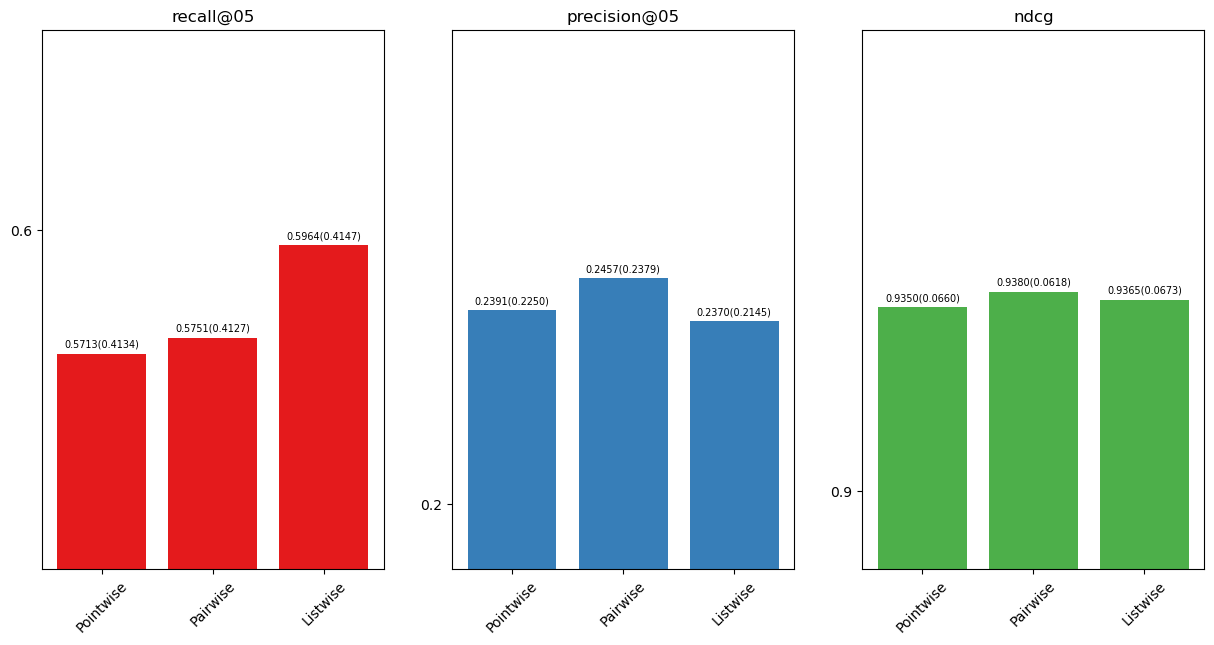

In [57]:
compare_methods(labels, results, metrics)

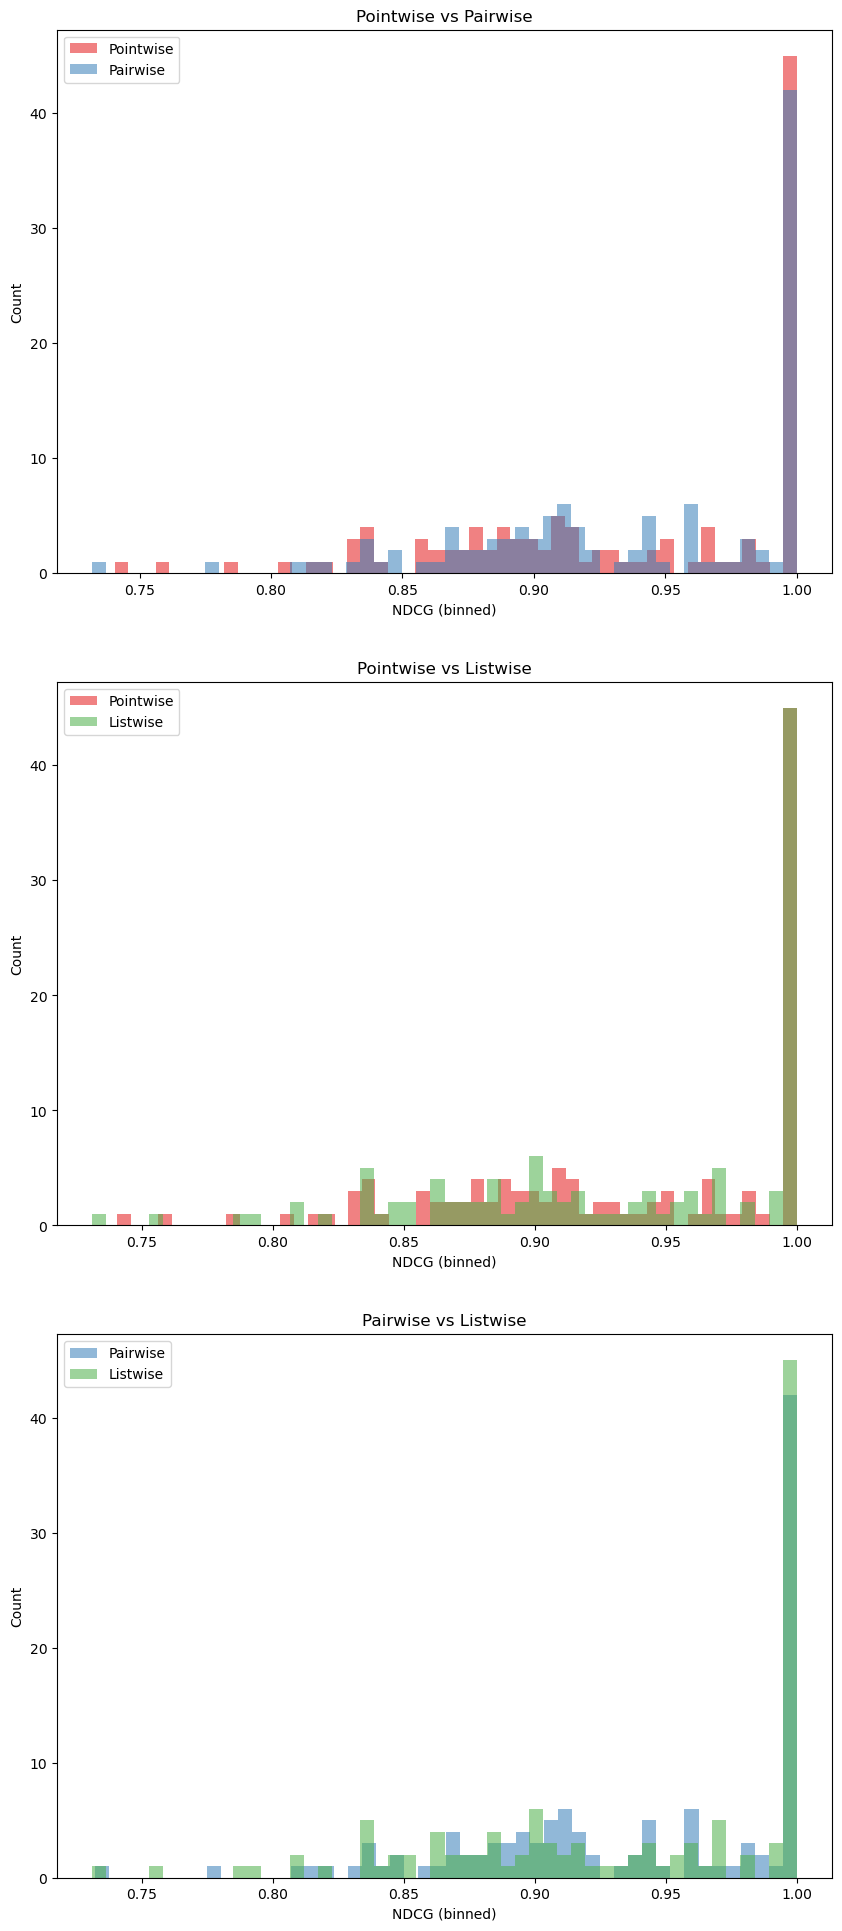

In [58]:
plot_distribution(labels, q_results)